### Reinforcement Learning Project! **[ANSWER SHEET]**

##### How to work through this project:
- Go cell by cell and finish the marked #TODO's
- You don't need to touch the code marked between the `#---------#`. Those are puzzle pieces that your code will fit into!
    - However, I **STRONGLY** encourage you to understand every single line between those blocks. They are essential!
    - It is crucial that your variable names are what we expect them to be, or the puzzle pieces won't fit.
- Tutorials/helpful information will be placed in the `.md` cells above the "work" cells. Consult them if you are stuck.
- If you REALLY cannot find the correct code to make the cell run, consult the `[proj]-ans.ipynb`.
- The final product (what we expect to see if you run all the cells consecutively) will be placed in the `answers/` directory.
    - Chances are your output won't be the exact same (stochasticity!) but it should be similar

In [1214]:
# Get used to these imports!
#----------------------------------------------------------------#
#To install: pip install numpy
import numpy as np 
#To install: pip install matplotlib
import matplotlib.pyplot as plt 
#To install: pip install torch (not GPU compatible)
import torch
import torch.nn as nn
#To install: pip install gymnasium[classic_control]
import gymnasium as gym

# No pip install needed
from IPython import display
import random
#----------------------------------------------------------------#

In this project, we will be implementing DQN for Cartpole, which is a common RL benchmark from OpenAI! First, lets visualize the environment that our Deep Q-Learnign Network will operate in. You can read more about cartpole [here](https://gsurma.medium.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288)

An excerpt is provided below if you would like to understand the dynamics of the system:

> ##### A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Run the following code to visualize the system dynamics.


In [1215]:
#----------------------------------------------------------------#
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.reset()

num_steps_to_viz = 0
for i in range(num_steps_to_viz):
   plt.imshow(env.render())
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(random.randrange(0,2)) # take a random action

env.close()
#----------------------------------------------------------------#

This is what the states represent (from the environment) and what the actions do (given to the environment)
```   
    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        ------------------------------------------------------
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24°           24°
        3	Pole Velocity At Tip      -Inf            Inf
        
    Action:
        Type: Discrete(2)
        Num	Action
        -------------------------------
        0	Push cart to the left
        1	Push cart to the right
```
These states are returned as some weird datatypes, but a little modification can easily turn them into tensors *(you will find this a common issue, turning things to/from tensors)*

Let us first create the Deep Q-Learning Network (DQN) that will play cartpole for us. If you remember from the lesson, Q-learning is powerful because it allows for "experience replay" where transitions can be saved inside of a memory buffer and then "re-experienced" by the model to learn. Note that technically this is not the Q-function as it only operates on the state and outputes an action. **This is more analogous to a raw policy.**

Take a look at your older projects for a refresher on how to make a neural network. The specification for the network itself is detailed below.

In [1216]:
# Goal: Make a DQN 
## TODO: Create a neural network called DQN that has variable input and output layer sizes (input variable should be state_dim, output is action_dim). 
## TODO: It should have 2+ layers with relu activations for all but the last layer, which should use an activation function that results in a probability distribution
"""
Tips:
- Hidden layers don't always have to be smaller than the layer before it! Especially if the input dimensionality is small
- Remind yourself what activations are and why they are useful. Which ones can result in a probability distribution?
- Make sure to name your class "DQN"
"""

"""
#! Answer
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()

        # Layers
        self.l1 = nn.Linear(state_dim, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, action_dim)
        
        # Activations
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, input):
        x = self.relu(self.l1(input))
        x = self.relu(self.l2(x))
        output = self.softmax(self.l3(x))
        return output
"""
import torch.nn.functional as F
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


Below I have defined a "named tuple" that will store a state "transition". Essentially it will hold a previous state (`state_a`) an action taken on that state (`action`), the resultant state from taking that state-action pair (`state_b`) and the reward for taking that state-action pair.

In [1217]:
#----------------------------------------------------------------#
from collections import namedtuple, deque

# Creates a named tuple that we can add to
Transition = namedtuple(
    "Transition",
    ('state_a', 'action', 'state_b', 'reward')
)

# Example of creating a named tuple

t = Transition([0,0,0,0], 1, [1,1], 0.5)

# You can check the value of, say, "action" by printing t.action

#----------------------------------------------------------------#

We will now be implementing a memory storage class that will be accessed in the training loop to "replay" memories to make the model better. What is nice about Q-learning is that "optimization is almost always performed off-policy, which means that each update can use data collected at any point during training, regardless of how the agent was choosing to explore the environment when the data was obtained." ([Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)). You can read more about Replay buffers [here](https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits)! Here are some important excerpts:
>More efficient use of previous experience, by learning with it multiple times. This is key when gaining real-world experience is costly, you can get full use of it. The Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial, especially when there is low variance in immediate outcomes (reward, next state) given the same state, action pair.

>Better convergence behaviour when training a function approximator. Partly this is because the data is more like i.i.d. data assumed in most supervised learning convergence proofs. 

Implement the following class. The spec has been written for you. You can read up on the deque class [here](https://docs.python.org/3/library/collections.html#collections.deque). It is the data structure we use to store Transition tuples.

In [1218]:
# Goal: Make a memory buffer storage object
## TODO: Implement the following class according to the spec
"""
Tips:
- Read up on how to use the deque object
- The random.sample() method may help you here
"""

class TransitionMemoryStorage():
    """A class to hold a buffer of transition tuples that can be sampled from to run experience replay on a DQN agent
    """
    def __init__(self, capacity):
        """Creates a buffer to hold transition tuples

        Args:
            capacity (int): How many elements the buffer can hold at a time
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def add_transition(self, t):
        """Adds a transition to the buffer

        Args:
            t (tuple): A Transition tuple
        """
        pass

    def sample(self, num_samples):
        """Selects num_samples unique samples from the buffer

        Args:
            num_samples (int): Number of samples to pull

        Returns:
            list: Sample list of transitions from the buffer
        """
        pass

    def can_sample(self, num_samples):
        """Checks if there are at least num_samples samples in the buffer

        Args:
            num_samples (int): How many samples to check validity for

        Returns:
            boolean: If the TransitionMemoryStorage object can be sampled on
        """
        pass
    
#! Answer
class TransitionMemoryStorage():
    """A class to hold a buffer of transition tuples that can be sampled from to run experience replay on a DQN agent
    """
    def __init__(self, capacity):
        """Creates a buffer to hold transition tuples

        Args:
            capacity (int): How many elements the buffer can hold at a time
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def add_transition(self, t):
        """Adds a transition to the buffer

        Args:
            t (tuple): A Transition tuple
        """
        self.buffer.append(t)

    def sample(self, num_samples):
        """Selects num_samples unique samples from the buffer

        Args:
            num_samples (int): Number of samples to pull

        Returns:
            list: Sample list of transitions from the buffer
        """
        return random.sample(list(self.buffer), num_samples)

    def can_sample(self, num_samples):
        """Checks if there are at least num_samples samples in the buffer

        Args:
            num_samples (int): How many samples to check validity for

        Returns:
            boolean: If the TransitionMemoryStorage object can be sampled on
        """
        return len(self.buffer) >= num_samples

We will now implement an explore/exploit strategy called "epsilon-greediness". This was explained in the megadoc but if you need a refresher check out this link [here](https://www.baeldung.com/cs/epsilon-greedy-q-learning#:~:text=The%20epsilon%2Dgreedy%20approach%20selects,what%20we%20have%20already%20learned.) and read section 5.2. We will use this class when deciding wether to explore (take a random action) or exploit (use the model and hope it knows what it's doign by then).

In [1219]:
import math
## TODO: Implement the following class according to the spec
"""
Tips:
- Look up ways the epsilon-greedy equation has been implemented and see which one works best here
- The `should_explore` method should have an <epsilon> probability of returning True where <epsilon> is the epsilon value at `current_step`
- Use random.random()
"""

class EpsilonGreedyStrategy():
    """Strategy for use in an agent, implements exponential decay epsilon greedy
    """
    def __init__(self, max_epsilon, min_epsilon, decay):
        """Initializes an Epsilon Greedy strategy

        Args:
            max_epsilon (float): The initial epsilon value
            min_epsilon (float): The ending epsilon value
            decay (float): The rate at which the epsilon value will decay
        """
        pass

    def should_explore(self, current_step):
        """Returns True if, according to this strategy at the current timestep, the agent should explore and False otherwise

        Args:
            current_step (int): How many steps the agent has taken (persists through episodes and failures)

        Returns:
            boolean: If the agent should explore (take a random action)
        """
        pass
    
    def _get_explore_prob(self, current_step):
        """Returns the epsilon value at a certain timestep

        Args:
            current_step (int): The number of steps that the agent has taken

        Returns:
            float: Epsilon value at this current timestep
        """
        pass
    
#! Answer
class EpsilonGreedyStrategy():
    """Strategy for use in an agent, implements exponential decay epsilon greedy
    """
    def __init__(self, max_epsilon, min_epsilon, decay):
        """Initializes an Epsilon Greedy strategy

        Args:
            max_epsilon (float): The initial epsilon value
            min_epsilon (float): The ending epsilon value
            decay (float): The rate at which the epsilon value will decay
        """
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay

    def should_explore(self, current_step):
        """Returns True if, according to this strategy, the agent should explore and false otherwise

        Args:
            current_step (int): How many steps the agent has taken (persists through episodes and failures)

        Returns:
            boolean: If the agent should explore (take a random action)
        """
        if(random.random() < self._get_explore_prob(current_step)):
            return True
        return False
    
    def _get_explore_prob(self, current_step):
        """Returns the epsilon value at a certain timestep

        Args:
            current_step (int): The number of steps that the agent has taken

        Returns:
            float: Epsilon value at this current timestep
        """
        return self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1. * current_step * self.decay)


Now we implement the Agent tht will actually interact with the environment. Read the tips carefully!

In [1220]:
# Goal: Create an Agent class that can navigate the environment
## TODO: Implement the following class according to the spec
"""
Tips:
- Be sure to increment the step counter whenever an action is selected
- If the strategy says to explore, select a random action. Otherwise, use the model!
- The model gives you probabilities (i.e. [0.74, 0.26]) saying which action it thinks is better. Use this information to choose an action.
- Scroll up to remind yourself what integers are valid actions (and therefore return values for `select_action`)
"""
class Agent():
    """Agent that acts within the environment using a dqn policy
    """
    def __init__(self, strategy):
        """Initializes the agent with a strategy for explore vs. exploit

        Args:
            strategy: Strategy object that dictates to explore or exploit
        """
        self.strategy = strategy
        self.current_step = 0

    def select_action(self, input_state, policy_dqn):
        """Selects an action based on a state and a policy network

        Args:
            input_state: The state to select an action based on
            policy_dqn: Policy network that outputs probabilities to take actions within the action space

        Returns:
            int: Action to take based on state
        """
        pass

#! Answer         
class Agent():
    """Agent that acts within the environment using a dqn policy
    """
    def __init__(self, strategy):
        """Initializes the agent with a strategy for explore vs. exploit

        Args:
            strategy: Strategy object that dictates to explore or exploit
        """
        self.strategy = strategy
        self.current_step = 0

    def select_action(self, input_state, policy_dqn):
        """Selects an action based on a state and a policy network

        Args:
            input_state: The state to select an action based on
            policy_dqn: Policy network that outputs probabilities to take actions within the action space

        Returns:
            int: Action to take based on state
        """
        self.current_step += 1
        if(self.strategy.should_explore(self.current_step)):
            # Explore
            return random.randint(0, 1)
        else:
            # Exploit
            with torch.no_grad():
                optimal_action = torch.argmax(policy_dqn(input_state))
                return optimal_action.item()
    

Good job! You're almost done with all the setup. Below are some small helper methods that will help you convert between different datatypes we will be working with.

In [1221]:
#----------------------------------------------------------------#
def t(np_arr):
    """Converts a numpy array to a tensor

    Args:
        numpy_array: Numpy array to convert

    Returns:
        Tensor with the data from the numpy array
    """
    return torch.from_numpy(np_arr)

def t_num(num):
    """Converts a single integer into a torch tensor

    Args:
        num (int/float): The integer to wrap

    Returns:
        Tensor with the data from the integer
    """
    return torch.tensor([num])
#----------------------------------------------------------------#

Finally, we get to the training loop. This is hard and requires some specific lines of code, and i made it myself so there is no tutorial online. However, the answer key does exist if you get stuck for too long.

We use two networks, the policy and the target network, with a slow update on the target network to match the policy one. This "lagging self-tuning" ensures the model wont be caught in a self-optimization loop. After all, DQN is based on optimizing the Bellman equation, not necessarily towards maximizing reward!

In [1222]:
from itertools import count
#! Answer
e_greedy_strategy = EpsilonGreedyStrategy(max_epsilon=0.9, min_epsilon=0.05, decay=0.99)
agent = Agent(strategy=e_greedy_strategy)
memory = TransitionMemoryStorage(1000)

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.0001)
loss_func = nn.SmoothL1Loss()

BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
target_update = 0

"""
def optimize_model():
    if(memory.can_sample(batch_size)):
        experiences = memory.sample(batch_size)

        for transition in experiences:
            current_q = policy_net(t(transition.state_a))[transition.action]
            next_q = torch.max(target_net(t(transition.state_b)))

            target_q_values = transition.reward + (GAMMA * next_q)

            loss = loss_func(current_q, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
"""

def optimize_model():
    if not memory.can_sample(BATCH_SIZE):
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.state_b)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.state_b if s is not None])
    state_batch = torch.cat(batch.state_a)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

num_episodes = 500
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    for t in count():
        action = agent.select_action(state, policy_net)
        observation, reward, terminated, truncated, _ = env.step(action)
        action = torch.tensor([action]).unsqueeze(1)
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Store the transition in memory
        memory.add_transition(Transition(state, action, next_state, reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

print('Complete')
"""
num_episodes = 1000
for episode in range(num_episodes):
    #print(f"Episode {episode}")
    current_state, _ = env.reset()
    done = False

    while not (done):
        action = agent.select_action(t(current_state), policy_net)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if (done):
            break

        memory.add_transition(Transition(current_state, action, next_state, reward))
        optimize_model()
        current_state = next_state
        
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)
"""


Complete


'\nnum_episodes = 1000\nfor episode in range(num_episodes):\n    #print(f"Episode {episode}")\n    current_state, _ = env.reset()\n    done = False\n\n    while not (done):\n        action = agent.select_action(t(current_state), policy_net)\n        next_state, reward, terminated, truncated, _ = env.step(action)\n        done = terminated or truncated\n\n        if (done):\n            break\n\n        memory.add_transition(Transition(current_state, action, next_state, reward))\n        optimize_model()\n        current_state = next_state\n        \n    target_net_state_dict = target_net.state_dict()\n    policy_net_state_dict = policy_net.state_dict()\n    for key in policy_net_state_dict:\n        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)\n    target_net.load_state_dict(target_net_state_dict)\n'

Now its time to test your model! The following method runs a few episodes and tells you the highest # of steps the agent was able to stay alive for across those episodes.

In [1236]:
#----------------------------------------------------------------#
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

num_trials = 100
overall_max_reward = 0

done = False
for i in range(10):
    episode_reward = 0
    for t in count():
        action = agent.select_action(state, policy_net)
        state,reward,terminated,truncated,_ = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        done = terminated or truncated

        episode_reward+=1
        overall_max_reward= max(episode_reward,overall_max_reward) 

        if done:
            break

print(f"Largest reward across {num_trials} trials: {overall_max_reward}")
#----------------------------------------------------------------#

Largest reward across 100 trials: 343


The following method visualizes one epsiode so you can see it!

KeyboardInterrupt: 

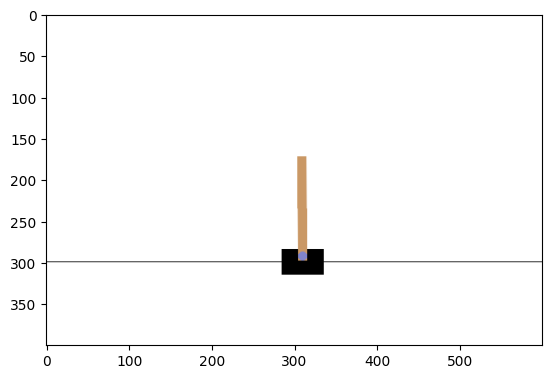

In [1224]:
#----------------------------------------------------------------#
env.reset()

for t in count():
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

    action = agent.select_action(state, policy_net)
    state,reward,terminated,truncated,_ = env.step(action)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    done = terminated or truncated
    if done:
        break

env.close()
print("Complete!")
#----------------------------------------------------------------#

Extensions:
- Change up the network and other hyperparameters
- Plot reward through time using matplotlib.pyplot
- Implement A2C (requires research)

### Congratulations on completing the project! Check your results with the notebook in the `answers` directory and then send your final accuracy to your club/channel/mentor!